In [1]:
import glob
import re
import bs4
import cltk
import nltk

import numpy as np
from collections import defaultdict, Counter
from nltk.tokenize.punkt import PunktLanguageVars

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram   

from sklearn.feature_extraction.text import TfidfVectorizer
from cltk.stop.latin.stops import STOPS_LIST

import itertools

stop_words = STOPS_LIST.extend(['quod', 'vel', 'sunt', 'hoc', 'vero', 'sit', 'sol', 'que', 'esse'])

%matplotlib inline

In [2]:
from cltk.corpus.utils.importer import CorpusImporter

corpus_importer = CorpusImporter('latin')
corpus_importer.import_corpus('latin_text_latin_library')
corpus_importer.import_corpus('latin_pos_lemmata_cltk')
corpus_importer.import_corpus('latin_models_cltk')

INFO:CLTK:Pulling latest 'latin_text_latin_library' from 'https://github.com/cltk/latin_text_latin_library.git'.
INFO:CLTK:Pulling latest 'latin_pos_lemmata_cltk' from 'https://github.com/cltk/latin_pos_lemmata_cltk.git'.
INFO:CLTK:Pulling latest 'latin_models_cltk' from 'https://github.com/cltk/latin_models_cltk.git'.


In [3]:
# This corpus comes from the Thesaurus Musicarum Latinarum.

corpus_files = glob.glob('corpus/html/*.html')

In [4]:
soups = [bs4.BeautifulSoup(open(file), 'lxml') for file in corpus_files]

In [5]:
def process_soup(soup):
    "Takes a bs4 BeautifulSoup object and returns a dict with document content and metadata."
    corpus_item = {}
    
    header = soup.find('p')

    original = " ".join([n for n in soup.findAll(text=True)])
    
    body = "".join([p.text for p in soup.findAll('p')[1:]])
    body = remove_newlines(body)
    body = remove_doublespace(body)
    body = remove_editorial_apparatus(body)
    body = join_hyphens(body)
    
    century_re = re.compile('.*www.chmtl.indiana.edu\/tml\/(\w+\W*\w+)\/.*')
    
    try:
        comments = "".join(soup.findAll(text=lambda text:isinstance(text, bs4.Comment)))
        century = century_re.match(comments).groups()[0]
        corpus_item['century'] = century
    except:
        corpus_item['century'] = 'nd'

    corpus_item['body'] = body.strip()
    corpus_item['id'] = soup.title.text.split(' ')[0]
    
    match = re.search(r"Author:\s(.*)", original)
    
    if match:
        result = match.group(1)
    else:
        result = ""
    
    corpus_item['author'] = result
    
    match = re.search(r"Title:\s(.*)", original)
    
    if match:
        result = match.group(1)
    else:
        result = ""
        
    corpus_item['title'] = result
    
    return corpus_item

def remove_editorial_apparatus(text):
    "Removes all text enclosed in square brackets."
    pattern = re.compile('\[.+?\]')
    return pattern.sub('', text)

def remove_newlines(text):
    "Replaces newlines with spaces."
    return text.replace('\n', ' ')

def remove_doublespace(text):
    "Removes any doublespaces."
    return text.replace('  ', ' ')

def join_hyphens(text):
    "Joins hyphens used at ends of lines."
    return text.replace('-\n', '')

def my_tokenize(document):
    "Tokenizes a document, represented as a string using Punkt."
    p = PunktLanguageVars()
    tokens = p.word_tokenize(document)
    tokens = [x.lower() for x in tokens if x not in (',', ';', '.', "'", '"',':',')','(', '|' , '||' )]
    return tokens

In [6]:
corpus = []

for soup in soups:
    try:
        corpus_item = process_soup(soup)    
        corpus.append(corpus_item)
    except:
        continue

In [7]:
len(corpus)

807

In [8]:
# Write texts stripped of boilerplate 
import unidecode

for item in corpus:
    with open('./corpus/body/{}.txt'.format(item['id']), 'w') as f:
        f.write(unidecode.unidecode(item['body']))

In [10]:
def prepare_id_info_map(corpus):
    id_info_map = {}
    for item in corpus:
        item_copy = item.copy()
        del item_copy['body']
        id_info_map[item['id']] = item_copy
    return id_info_map

In [11]:
id_info_map = prepare_id_info_map(corpus)

In [12]:
id_info_map['AARIH1']

{'author': 'Aaron, Petrus',
 'century': '16th',
 'id': 'AARIH1',
 'title': 'De institutione harmonica, liber primus'}

In [13]:
def filter_stopwords(tokens):
    "Filters stopwords from list of tokens."
    return [token for token in tokens if token not in STOPS_LIST]

def filter_shortwords(tokens, short_size=2):
    "Filters tokens of size greater than short_size from list of tokens."
    return [token for token in tokens if len(token) > short_size]

In [14]:
from cltk.stem.lemma import LemmaReplacer

lemmatizer = LemmaReplacer('latin')

In [15]:
def prep(document):
    "A convenience function which applies a series of operations to a document represented in a string."
    tokenized = my_tokenize(document)
    stopped = filter_stopwords(tokenized)
    shorted = filter_shortwords(stopped)
    lemmatized = lemmatizer.lemmatize(shorted)
    done = lemmatized
    return done

## Topic Modeling with `gensim`

In [37]:
import gensim

In [38]:
documents = [prep(doc['body']) for doc in corpus]

In [41]:
dictionary = gensim.corpora.Dictionary(documents)

In [65]:
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]
len(bow_corpus)

807

In [55]:
gensim.corpora.MmCorpus.serialize('tml.mm', bow_corpus)

In [56]:
bow_corpus = gensim.corpora.MmCorpus('tml.mm')

In [68]:
tfidf = gensim.models.TfidfModel(bow_corpus, normalize=True)
tfidf_corpus = tfidf[bow_corpus]

In [70]:
lsi = gensim.models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=150)

In [75]:
lsi.print_topics(100)[60:90]

['0.163*"gradus" + -0.162*"caput" + -0.137*"existens" + 0.116*"discantus" + 0.112*"tropus" + -0.103*"authenticus" + 0.099*"antiphona" + 0.091*"lis." + -0.088*"diapente" + -0.080*"discantare"',
 '-0.188*"caput" + 0.157*"divisor" + 0.111*"uncia" + 0.106*"obolus" + 0.105*"<capitulum" + -0.099*"longus" + 0.099*"arcus" + -0.097*"filum" + -0.096*"seculorum" + -0.095*"biscantus"',
 '-0.163*"antiphona" + 0.123*"existens" + 0.117*"divisor" + -0.086*"saeculum" + 0.086*"lis." + 0.083*"uncia" + -0.082*"diatonos" + 0.082*"exemplum." + -0.082*"amen" + -0.077*"amen."',
 '-0.173*"mensuratorum" + -0.147*"plusquamperfectus" + -0.119*"planus1" + 0.114*"discantus" + -0.114*"mensuratus" + -0.098*"concordancias" + -0.097*"concordanciis" + -0.093*"tropus" + 0.092*"converro" + 0.092*"<capitulum"',
 '-0.141*"..." + 0.135*"amen." + 0.132*"lis." + 0.124*"saeculum" + -0.108*"diatessaron" + 0.104*"existens" + -0.103*"f-faut" + -0.099*"/p." + -0.095*"armoniarum" + 0.091*"quandocunque"',
 '-0.160*"filum" + 0.131*"ca

## Focusing on a subset

This is some code to restrict sample to a certain set of parameters

TODO: Make a proper query interface for corpus entries

In [15]:
q_century = '17th'
q_min_size = 50
q_max_size = 10000000

sample = [treatise for treatise in corpus\
          if treatise['century'] == q_century\
          and len(treatise['body']) < q_max_size\
          and len(treatise['body']) > q_min_size]

bodys = [treatise['body'] for treatise in sample]
ids = [treatise['id'] for treatise in sample]
titles = [treatise.get('title', 'nt')[:15] for treatise in sample]
authors = [treatise.get('author', 'na')[:15] for treatise in sample]

len(sample) , len(ids), len(titles)

(8, 8, 8)

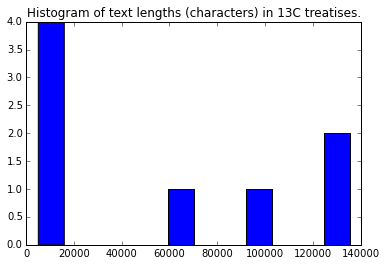

In [17]:
lengths = [len(treatise['body']) for treatise in sample]
plt.hist(lengths, bins=12)
plt.title('Histogram of text lengths (characters) in 13C treatises.')
plt.show()

## Text Similarity - Ward clustering in tf-idf space

In [18]:
documents = [doc['body'] for doc in corpus]

tfidf = TfidfVectorizer(tokenizer=prep, stop_words=stop_words)
tfs = tfidf.fit_transform(documents)

KeyboardInterrupt: 

In [1]:
# bodys is the sample only from the 13th century 

tfs = tfidf.transform(bodys)
tfs.shape

dist = 1 - cosine_similarity(tfs)

NameError: name 'tfidf' is not defined

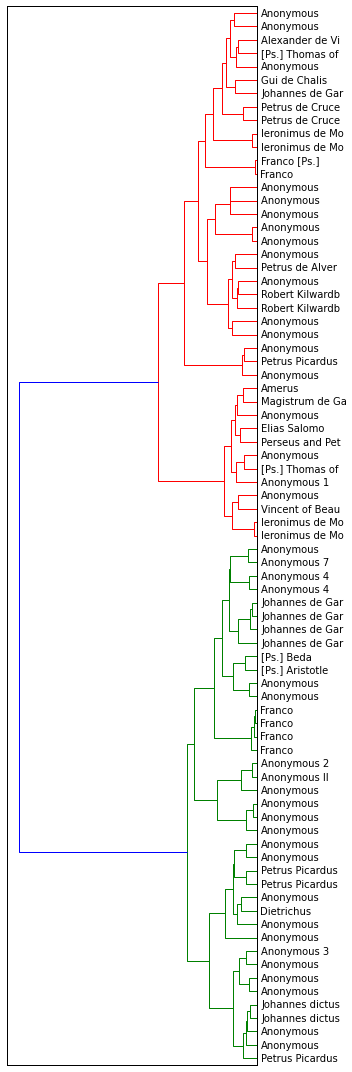

In [33]:
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(5, 15)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=authors);

plt.tick_params(axis='x',          
    which='both',      
    bottom='off',      
    top='off',         
    labelbottom='off')

plt.tight_layout() 

## Text reuse - Viral Texts

Reimplementation of the Viral Texts methodology

viraltexts.org

Note that this is done at the "section" level - will need to "sectionize" documents first.

Part I. Identify document pair candidates

1. Pick out a subset of all the texts for testing purposes
2. Sectionalize
3. ~~Make a hashmap id -> tokenized text~~
4. Make a hashmap id -> shingled text
5. For each n-gram, create a list of (d_i, p_i) - document ID and position ID
6. Exclude singleton n-grams
7. Extract candidate pairs
8. Filter (e.g. suppress n-grams that generate more than some fixed number of pairs)
9. Rank

Part II. Local document alignment

1. Do Smith-Waterman on top pairs

In [16]:
import random

N = 5

def zipngram(document_tokens,n=N):
    return zip(*[document_tokens[i:] for i in range(n)])

In [65]:
def prepare_ngram_index(id_shingled_map):
    ngram_index = defaultdict(list)
    
    for _id, shingled_rep in id_shingled_map.items():
        for position, n_gram in enumerate(shingled_rep):
            ngram_index[n_gram].append((_id, position))
    
    return ngram_index

def filter_singletons(ngram_index):
    # Naive implementation not advised in article
    # TODO: Implement nice two-pass hash fxn. method
    filtered_ngram_index = {}
    
    for ngram, locations in ngram_index.items():
        if len(locations) > 1:
            filtered_ngram_index[ngram] = locations
    
    return filtered_ngram_index

def prepare_id_tokenized_map(corpus):
    id_tokenized_map = {}
    
    for text in corpus:
        id_tokenized_map[text['id']] = my_tokenize(text['body'])
        
    return id_tokenized_map

def prepare_id_body_map(corpus):
    id_body_map = {}
    
    for text in corpus:
        id_body_map[text['id']] = text['body']
            
    return id_body_map 

def prepare_id_shingled_map(corpus): 
    id_shingled_map = {}
    
    for text in corpus:
        tokenized_body = my_tokenize(text['body'])
        id_shingled_map[text['id']] = [ngram for ngram in zipngram(tokenized_body, N)]
    
    return id_shingled_map

def prepare_pair_ngrams_map(ngram_index):
    pair_ngrams_map = defaultdict(list)
    
    for ngram, locations in ngram_index.items():
        documents = list(set([location[0] for location in locations]))
        for p in itertools.combinations(documents, 2):
            if p[0][:3] != p[1][:3]:
                pair_ngrams_map[p].append(ngram)
    
    return pair_ngrams_map

In [54]:
corpus[0].keys()

dict_keys(['century', 'id', 'body', 'author', 'title'])

In [55]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i+n]
    
def sectionalize_corpus(corpus, section_length=50):
    sectionalized_corpus = []
    for item in corpus:
        words = item['body'].split(' ')
        for index, chunk in enumerate(chunks(words, section_length)):
            old_id = item.get('id')
            new_item = item.copy()
            new_item['id'] = old_id + '_{}'.format(index)
            new_item['body'] = ' '.join(chunk)
            sectionalized_corpus.append(new_item)
    return sectionalized_corpus        

In [56]:
sc = sectionalize_corpus(corpus)

In [57]:
sc[100]

{'author': 'Jacobus Leodiensis',
 'body': 'b mollem secundum ut de F; sed re per  durum secundum ut de G. Et consimili modo intelligendum est de distinctis vocibus in aliis positis clavibus. Ex his etiam videri potest quare in tribus primis litteris et in ultima sunt sole voces, quare in quarta due, in quinta due,',
 'century': '14th',
 'id': 'JACSM6B_100',
 'title': 'Speculum musicae, Liber sextus'}

In [66]:
%time id_body_map = prepare_id_body_map(sc)

CPU times: user 80.5 ms, sys: 58 ms, total: 138 ms
Wall time: 157 ms


In [37]:
%time id_tokenized_map = prepare_id_tokenized_map(sc)

CPU times: user 16.4 s, sys: 181 ms, total: 16.6 s
Wall time: 16.7 s


In [38]:
%time id_shingled_map = prepare_id_shingled_map(sc)

CPU times: user 18 s, sys: 2.31 s, total: 20.4 s
Wall time: 20.6 s


In [39]:
%time idx = prepare_ngram_index(id_shingled_map)

CPU times: user 21.7 s, sys: 31.7 s, total: 53.3 s
Wall time: 59.3 s


In [40]:
%time filtered_idx = filter_singletons(idx)

CPU times: user 3.34 s, sys: 3.51 s, total: 6.85 s
Wall time: 7.54 s


In [26]:
assert len(idx) > len(filtered_idx)

----
Let's have a look inside this index, shall we?

In [37]:
def ngram_index_freq(index, blacklist=[]):
    freqs = Counter()
    for ngram, locations in index.items():
        if not bool(set(ngram) & set(blacklist)):
            freqs[ngram] += len(locations)
    return freqs

In [38]:
freq = ngram_index_freq(filtered_idx)
freq.most_common(20)

[(('c', 'd', 'e', 'f', 'g'), 656),
 (('a', 'b', 'c', 'd', 'e'), 428),
 (('b', 'c', 'd', 'e', 'f'), 416),
 (('ut', 're', 'mi', 'fa', 'sol'), 337),
 (('re', 'mi', 'fa', 'sol', 'la'), 316),
 (('d', 'e', 'f', 'g', 'a'), 253),
 (('in', 'g', 'sol', 're', 'ut'), 228),
 (('in', 'a', 'la', 'mi', 're'), 221),
 (('in', 'c', 'sol', 'fa', 'ut'), 178),
 (('a', 'c', 'd', 'e', 'f'), 138),
 (('e', 'f', 'g', 'a', 'b'), 126),
 (('g', 'a', 'b', 'c', 'd'), 126),
 (('f', 'g', 'a', 'b', 'c'), 121),
 (('aut', 'duos', 'tres', 'aut', 'quatuor'), 118),
 (('re', 'mi', 'fa', 'sol', 'la.'), 111),
 (('d', 'e', 'f', 'g', 'aa'), 110),
 (('in', 'd', 'la', 'sol', 're'), 109),
 (('gloria', 'patri', 'et', 'filio', 'et'), 108),
 (('patri', 'et', 'filio', 'et', 'spiritui'), 103),
 (('c.', 'd.', 'e.', 'f.', 'g.'), 100)]

There's a lot of scale segments... We could do a couple of things about this, I suppose. Let's find out the most common tokens in the dataset and exclude any ngrams from this list which contain a token that appears close to the top of that list.

In [55]:
def count_all_tokens(id_tokenized_map):
    all_tokens = []
    for _id, tokens in id_tokenized_map.items():
        all_tokens.extend(tokens)
    return Counter(all_tokens)

In [56]:
token_counter = count_all_tokens(id_tokenized_map)

In [57]:
def top_n_tokens(id_tokenized_map, n):
    token_counter = count_all_tokens(id_tokenized_map)
    return [t[0] for t in token_counter.most_common(n)]

top_100_tokens = top_n_tokens(id_tokenized_map, 100)

In [58]:
freq = ngram_index_freq(filtered_idx, blacklist=top_100_tokens)
freq.most_common(20)

[(('c.', 'd.', 'e.', 'f.', 'g.'), 100),
 (('b.', 'c.', 'd.', 'e.', 'f.'), 70),
 (('a.', 'b.', 'c.', 'd.', 'e.'), 64),
 (('1', '2', '3', '4', '5'), 39),
 (('2', '3', '4', '5', '6'), 39),
 (('3', '4', '5', '6', '7'), 38),
 (('aa', 'bb', 'cc', 'dd', 'ee'), 38),
 (('4', '5', '6', '7', '8'), 30),
 (('d.', 'e.', 'f.', 'g.', 'a.'), 29),
 (('divisio', 'ii', 'authenticus', 'protus', 'antiphona'), 29),
 (('hypate', 'meson', 'parhypate', 'meson', 'lichanos'), 27),
 (('acuti', 'soni', 'gravisque', 'mixtura', 'suaviter'), 27),
 (('hypate', 'hypaton', 'parhypate', 'hypaton', 'lichanos'), 26),
 (('h', 'i', 'k', 'l', 'm'), 26),
 (('gravisque', 'mixtura', 'suaviter', 'uniformiterque', 'auribus'), 26),
 (('k', 'l', 'm', 'n', 'o'), 25),
 (('mediatis', 'manus', 'musicalis', 'partibus', 'existentium'), 25),
 (('.a.', 'secundus', '.b.', 'tertius', '.c.'), 24),
 (('i', 'k', 'l', 'm', 'n'), 24),
 (('hypaton', 'hypate', 'meson', 'parhypate', 'meson'), 24)]

A bit better this time. Let's check out the provenance of the phrase:

> acuti soni gravisque mixtura suaviter

which appears 26 times in the corpus.

In [59]:
locations = filtered_idx[('acuti', 'soni', 'gravisque', 'mixtura', 'suaviter')]
for _id, position in locations:
    info = id_info_map[_id]
    print(_id, info['author'][:15], info['title'][:15], position, info['century'])

UGODEC1A Ugolino Urbevet Declaratio musi 15249 15th
REGDHI Regino Prumiens De harmonica in 2769 9th-11th
REGHAR Regino Prumiens Epistola de har 2830 9th-11th
ANODUL2 Anonymous Dulce ingenium  1614 9th-11th
IERTRA1 Ieronimus de Mo Tractatus de mu 14204 13th
GUIENC Guillermus de P Enchiridion de  580 15th
UGODEC5 Ugolino Urbevet Declaratio musi 3188 15th
UGODEC5 Ugolino Urbevet Declaratio musi 5560 15th
UGODEC5 Ugolino Urbevet Declaratio musi 5912 15th
ANO1DEM Anonymous I De musica antiq 7750 14th
MURMSPE Johannes de Mur Musica speculat 984 14th
BOEMUS1 Boethius, Anici De institutione 3413 6th-8th
MARLUC5 Marchetus de Pa Lucidarium, tra 50 14th
MURMUS Johannes de Mur Tractatus de mu 3804 14th
BOEDIM1 Boethius, Anici De institutione 3104 6th-8th
QUAPRIB4 Anonymous Quatuor Princip 9641 14th
MURMSPEW Johannes de Mur Musica speculat 970 14th
MURMSP Johannes de Mur Musica speculat 960 14th
JACCDM Jacobus Leodien Compendium de m 390 14th
JACSP2A Jacobus Leodien Speculum musica 5137 14th
CICNM1

How about this for a research question?

> What treatises does Descartes allude to/paraphrase in his *Compendium*?

1. Use id_shingled_map to get the shingled version of Descartes' text, 'DESCOM'
2. Look up each n-gram in the filtered_idx for concordances
3. Filter out disinteresting ones
4. Print out the output

In [61]:
query_id = 'DESCOM'
query_shingled = [ngram for ngram in id_shingled_map[query_id]]

In [62]:
len(query_shingled)

9034

So we're going to make 9034 calls on the index. Let's use a generator expression.

In [66]:
response = []

for query_ngram in query_shingled:
    locations = filtered_idx.get(query_ngram, None)
    if locations is not None:
        response.append((query_ngram, locations))

In [69]:
response

[(('vnde', 'fit', 'vt', 'verbi', 'gratiâ'),
  [('DESCOM', 145), ('DESCOM', 183)]),
 (('vnde', 'fit', 'vt', 'verbi', 'gratiâ'),
  [('DESCOM', 145), ('DESCOM', 183)]),
 (('cuius', 'ratio', 'est', 'quia', 'non'),
  [('MARPOME', 13105), ('MARPOM', 12634), ('DESCOM', 273)]),
 (('a', 'b', 'et', 'b', 'c'),
  [('SALMUS3', 24673),
   ('SALMUS4', 15597),
   ('STAPMUS', 1967),
   ('STAPMUS', 6644),
   ('STAPMUS', 18388),
   ('DESCOM', 325)]),
 (('in', 'sonis', 'qui', 'simul', 'emittuntur'),
  [('DESCOM', 1110), ('DESCOM', 1172)]),
 (('in', 'sonis', 'qui', 'simul', 'emittuntur'),
  [('DESCOM', 1110), ('DESCOM', 1172)]),
 (('tunc', 'a', 'c', 'a', 'b'), [('MURMSPEW', 6970), ('DESCOM', 1364)]),
 (('a', 'b', 'in', 'tres', 'partes'), [('MURMSPEW', 5030), ('DESCOM', 1392)]),
 (('vel', 'in', 'quinque', 'vel', 'in'),
  [('MARPOM', 17890), ('DESCOM', 1432)]),
 (('qui', 'cum', 'vno', 'octavae', 'termino'),
  [('DESCOM', 1600), ('DESCOM', 2119)]),
 (('qui', 'cum', 'vno', 'octavae', 'termino'),
  [('DESCOM', 

----
And, back to the Viral Texts methodology...

Continuing to search for candidate document pairs, let's go on an make a dict that has pairs of documents as its keys and a list of ngrams that each share is its values.

In [58]:
%time pair_ngrams_map = prepare_pair_ngrams_map(filtered_idx)

CPU times: user 8 s, sys: 3.15 s, total: 11.1 s
Wall time: 12.1 s


In [59]:
def p_n_map_ngrams_freq(pair_ngrams_map):
    freqs = Counter()
    for pair, ngrams in pair_ngrams_map.items():
        freqs[pair] += len(ngrams)
    return freqs

In [60]:
freq = p_n_map_ngrams_freq(pair_ngrams_map)

Do Smith-Waterman

In [88]:
from Bio import pairwise2

alignments = []

for count in freq.most_common()[100:110]:
    print(count[0])
    text_a_id, text_b_id = count[0][0], count[0][1]
    text_a = id_body_map[text_a_id]
    text_b = id_body_map[text_b_id]
    a = pairwise2.align.localms(text_a, text_b, 2, -1, -.5, -.1)
    alignments.append(a)

('PEPESUM_356', 'MURSUM_357')
('PEPESUM_43', 'MURSUM_43')
('ADEMUS_33', 'BOEMUS4_88')
('IERTDM1_97', 'VINSPE_39')
('MURSUM_338', 'PEPESUM_337')
('SCENCH_5', 'SCHENC_5')
('ARIDEM_192', 'GUICOMS_383')
('IERTRA1_625', 'BOEDIM3_94')
('BOEMUS1_89', 'IERTRA1_334')
('BOEDIM1_82', 'IERTRA1_333')


In [87]:
for item in alignments:
    print(item[0])

('---p------------l------u-rim-------u---m canentium duobus modis- ita quod unus ascendat, reliquus vero descendat- et e contrario; pausando tamen conveniunt maxime vel in eodem- vel in diapente- vel in diapason. Dicitur -autem organica ab organo, quod est instrumentum canendi, quia in tali specie cantus multum laborat. Triphonia est melodia sive modus canendi a', 'dyaphonia est melodia duorum vel plurium canentium duobus modis, ita quod unus ascendat, reliquus vero descendat, et e contra---; pausando tamen conveniunt maxime vel in eodem, vel in diapente, vel in diapason. Dicitur  autem organica ab organo, quod est instrumentum canendi, quia in tali specie cantus multum laborat. Triph-----------------------o--------n-i-a', 288.0, 3, 362)
('tanta immo innumerabiliter plura music-e reperiantur pr-econia, statuerunt primo Ignatius, et post beatus Ambrosius Mediolanensis archiepiscopus, ut in ecclesia deo serviretur per cantum propter maiorem eius reverentiam et honorem. Ordinantes igitur-

Create a borrowing network

In [38]:
def p_n_map_to_weighted_edges(pair_ngrams_map, min_ngrams=50, max_ngrams=5000):
    edges = []
    for pair, ngrams in pair_ngrams_map.items():
        if min_ngrams < len(ngrams) < max_ngrams:
            edges.append("{},{},{}\n".format(pair[0], pair[1], len(ngrams)))
    
    return edges

In [39]:
edges = p_n_map_to_weighted_edges(pair_ngrams_map)

In [40]:
def write_edges_to_file(edges, file=open('graph.txt', 'w')):
    file.write('source,target,weight\n')
    file.writelines(edges)
    file.close()

In [41]:
write_edges_to_file(edges)

## Text reuse - Naive n-gram recurrence heatmap

Could reuse the indexes generated to acheive the same ends.

1. Convert each document to a list of n-grams (say n=3)
2. Convert the remainder of the corpus to a list of n-grams (same n), and that into a Counter
3. For each document, iterate through the list of n-grams
4. If the n-gram is appears in the rest of the corpus, make a note of that and how many times it appears
5. End up with a "heatmap" of reuse

In [67]:
from nltk.util import ngrams

import itertools

N = 3

sample = random.sample(corpus, 25)
bodys = [item['body'] for item in sample]
ids = [item['id'] for item in sample]

corpus_tokens_list = [my_tokenize(document) for document in bodys]

In [68]:
def zipngram(document_tokens,n=N):
    return zip(*[document_tokens[i:] for i in range(n)])

def generate_slice(index, document, sample):
    # Document being studied for text reuse
    document = document
    # Make a list of the other documents
    others = [d for j, d in enumerate(sample) if j != index]

    # Tokenize
    document_tokens = my_tokenize(document)
    others_tokens_list = corpus_tokens_list

    # Get n-grams
    document_ngrams_generator = zipngram(document_tokens, N)
    document_ngrams = [x for x in document_ngrams_generator]
    others_ngrams_list = [zipngram(other_tokens, N) for other_tokens in others_tokens_list]

    # Create counter implemented with defaultdict for remainders
    flat = itertools.chain(*others_ngrams_list)
    o_counter = Counter(flat)

    heatslice = [o_counter.get(ngram, 0) for ngram in document_ngrams]
    return heatslice, document_ngrams

In [69]:
def construct_heatmap():
    for index, document in enumerate(bodys):
        a_slice = generate_slice(index, document, bodys)
        heatmap.append(a_slice[0])
        documents_ngrams.append(a_slice[1])

In [70]:
def plot_heatmap2():
    f, axarr = plt.subplots(len(heatmap), figsize=(15, 20))
    for index, data in enumerate(heatmap):
        h = np.array(data)
        x = np.empty([2,h.shape[0]])
        x[:,:] = h
        axarr[index].contourf(x)
    f.show()

In [71]:
def plot_heatmap():
    length = len(sorted(heatmap,key=len, reverse=True)[0])
    hm = np.array([xi+[0]*(length-len(xi)) for xi in heatmap])
    fig, ax = plt.subplots(figsize=(15, 20))
    ax.set_yticks(np.arange(hm.shape[0])+0.5, minor=False)
    ax.set_yticklabels(ids)
    ax.pcolormesh(hm)
    fig.show()

In [72]:
heatmap = []
documents_ngrams = []

%matplotlib inline
construct_heatmap()

/home/eamonn/Projects/tml-corpus/venv/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


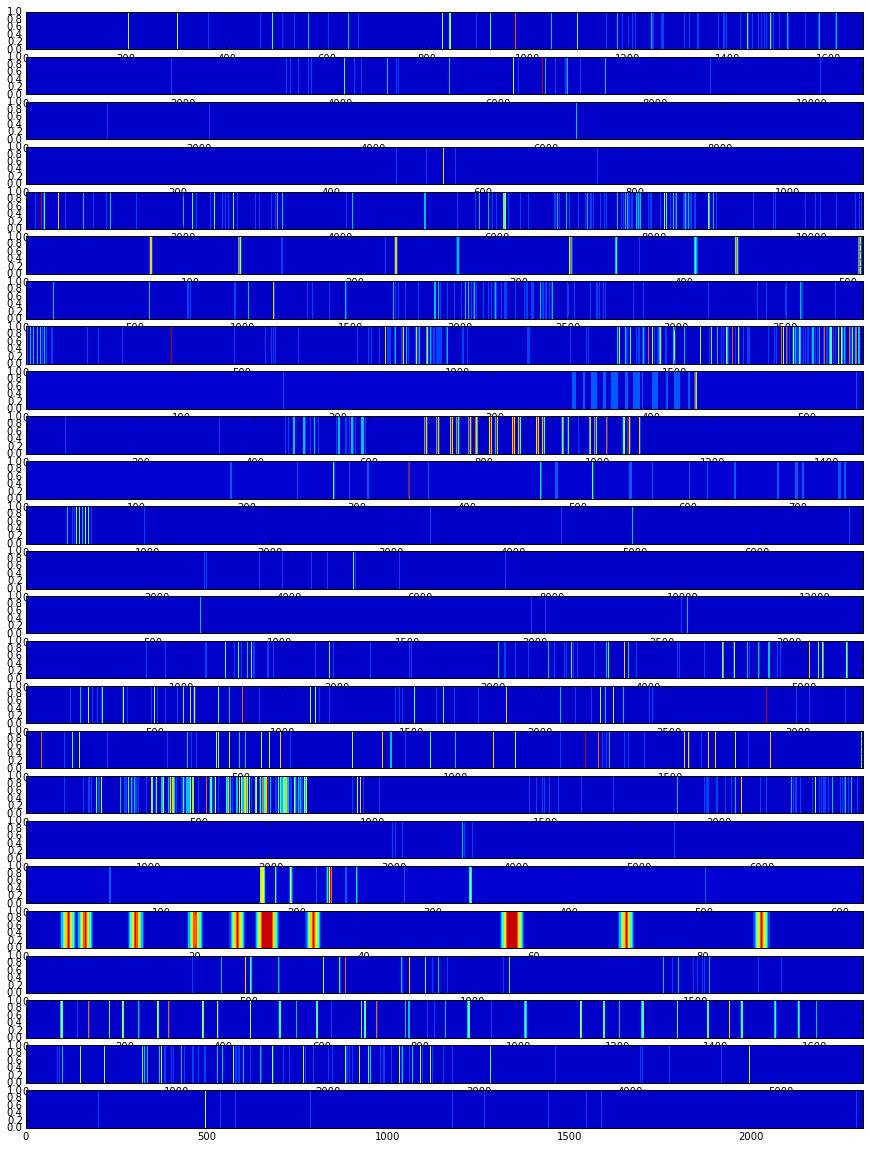

In [73]:
plot_heatmap2()